In [ ]:
# dataset - https://www.kaggle.com/datasets/vfomenko/young-affectnet-hq

In [43]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn 
import torch.nn.functional as F
from torch.optim import Adam, AdamW, RMSprop, Adagrad

import shutil
import os
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm

In [ ]:
# shutil.rmtree("/kaggle/working/")

In [12]:
os.makedirs("/kaggle/working/data", exist_ok=True)

In [13]:
def copy_structure(src, dest):
    if not os.path.exists(dest):
        os.makedirs(dest)
    
    for dirpath, dirnames, filenames in os.walk(src):
        dest_path = dirpath.replace(src, dest, 1)
        if not os.path.exists(dest_path):
            os.makedirs(dest_path)
        
        for filename in tqdm(filenames): 
            src_file = os.path.join(dirpath, filename)
            dest_file = os.path.join(dest_path, filename)
            shutil.copy2(src_file, dest_file)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
device

'cuda'

In [17]:
dir_from = "/kaggle/input/young-affectnet-hq"
dir_to = '/kaggle/working/data'
copy_structure(dir_from, dir_to)

0it [00:00, ?it/s]
100%|██████████| 1822/1822 [00:01<00:00, 1282.73it/s]


In [18]:
path = '/kaggle/working/data'
for dir in tqdm(os.listdir('/kaggle/working/data')):
    if dir in ["contempt", "disgust", "surprise", "sad"]:
        dir_path = os.path.join(path, dir)
        shutil.rmtree(dir_path)

100%|██████████| 8/8 [00:00<00:00, 21.83it/s]


In [19]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size

folder_happy = '/kaggle/working/data/happy'
folder_neutral = '/kaggle/working/data/neutral'
folder_angry = '/kaggle/working/data/anger'
folder_fear = '/kaggle/working/data/fear'


size_happy = get_folder_size(folder_happy)
size_neutral = get_folder_size(folder_neutral)
size_angry = get_folder_size(folder_angry)
size_fear = get_folder_size(folder_fear)

size_happy_mb = size_happy / (1024 * 1024)
size_neutral_mb = size_neutral / (1024 * 1024)
size_angry_mb = size_angry / (1024 * 1024)
size_fear_mb = size_fear / (1024 * 1024)

print(f"Folder 'happy': {size_happy_mb:.2f} MB")
print(f"Folder 'neutral': {size_neutral_mb:.2f} MB")
print(f"Folder 'anger': {size_angry_mb:.2f} MB")
print(f"Folder 'fear': {size_fear_mb:.2f} MB")


Folder 'happy': 2090.02 MB
Folder 'neutral': 2029.96 MB
Folder 'anger': 122.13 MB
Folder 'fear': 119.37 MB


In [ ]:
import os
from PIL import Image
from tqdm import tqdm

def convert_png_to_jpg_and_delete_png(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

       
        if filename.endswith('.png'):
            try:
               
                img = Image.open(file_path)
                img = img.convert('RGB')
                
                
                new_filename = os.path.splitext(filename)[0] + '.jpg'
                new_file_path = os.path.join(folder_path, new_filename)
                
        
                img.save(new_file_path, 'JPEG')
                print(f"Converted: {filename} -> {new_filename}")
                
                os.remove(file_path)
                print(f"Deleted: {filename}")
            except Exception as e:
                print(f"Cannot convert or delete: {filename}: {e}")

folders = ['/kaggle/working/data/neutral', '/kaggle/working/data/happy']

for folder in tqdm(folders):
    convert_png_to_jpg_and_delete_png(folder)


In [21]:
root_dir = '/kaggle/working/data'
dataset = datasets.ImageFolder(root_dir, transform=None)

In [22]:
len(dataset)

7403

In [23]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor() 
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [24]:
class CustomTransform(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [25]:
train_set, test_set, val_set = random_split(dataset, [0.8, 0.1, 0.1])

In [26]:
train_data = CustomTransform(train_set, transform = train_transform)
val_data = CustomTransform(val_set, transform = val_transform)
test_data = CustomTransform(test_set, transform = test_transform)

In [27]:
len(train_set), len(val_set), len(test_set)

(5923, 740, 740)

In [28]:
len(train_data), len(val_data), len(test_data)

(5923, 740, 740)

In [29]:
classes = dataset.classes
classes

['anger', 'fear', 'happy', 'neutral']

In [30]:
def output(data, limit):
    count = 0
    limit = limit
    emotions = ['anger', 'fear', 'happy', 'neutral']
    
    for x, y in data:
        
        count += 1
        
        x = x.permute(1, 2, 0)
        plt.imshow(x)
        plt.title(emotions[int(y)])
        plt.show()
    
        if count >= limit:
            break


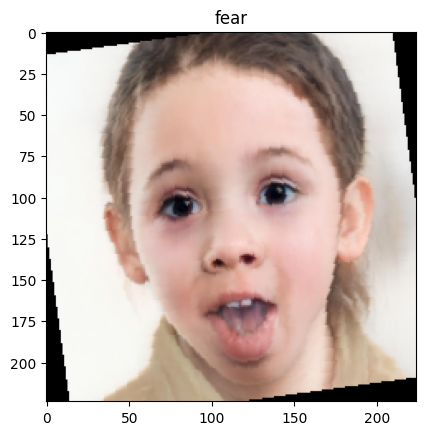

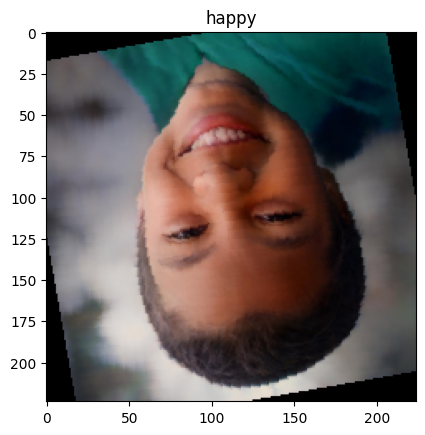

In [22]:
output(train_data, 2)

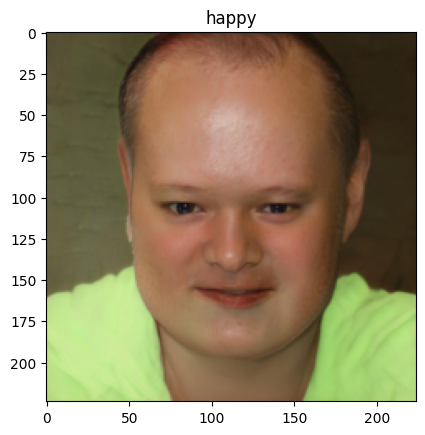

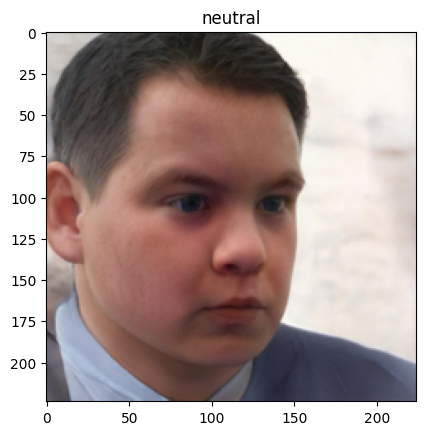

In [24]:
output(val_data, 2)

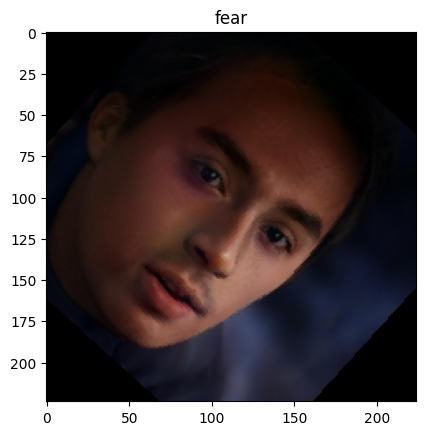

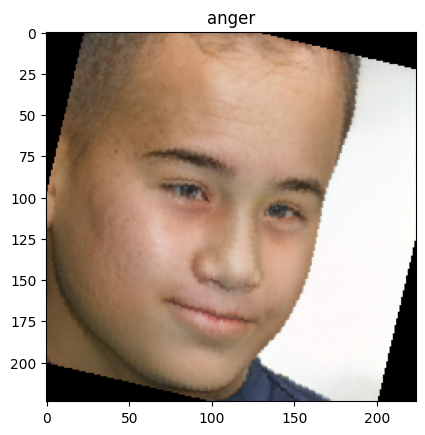

In [25]:
output(test_data, 2)

In [33]:
batch_size = 64

train_dl = DataLoader(train_data, batch_size=batch_size, generator=torch.Generator(device = "cpu"), shuffle=True)
val_dl = DataLoader(val_data, batch_size=batch_size, generator=torch.Generator(device = "cpu"), shuffle=True)

In [66]:
class SkipBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool = False):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        
        if pool == True:
            self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        else:
            self.pool = None
            
        self.add_con = nn.Sequential()
        
        if in_channels != out_channels:
            self.add_con = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
            
    def forward(self, x):
        out = self.conv1(x)
        add_out = self.add_con(x)
        
        out = F.relu(out)
        out = self.conv2(out)
        
        out += add_out
        
        if self.pool:
            out = self.pool(out)
            
        out = F.relu(out)
        
        return out
            
        

In [67]:
tensor = torch.rand(3, 224, 224)

block1 = SkipBlock(3, 32, pool = True)
block2 = SkipBlock(32, 64, pool = True)
block3 = SkipBlock(64, 128, pool = False)

out = block1(tensor)
out = block2(out)
out = block3(out)
out.shape

torch.Size([128, 56, 56])

In [28]:
# class MultiSkipBlock(nn.Module):
#     #                    64            512
#     def __init__(self, in_channels, out_channels, pool = False):
#         super().__init__()
        
#         self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = in_channels * 2, kernel_size = 3, padding = 1)
#         self.conv2 = nn.Conv2d(in_channels = in_channels * 2, out_channels = in_channels * 4, kernel_size = 3, padding = 1)
#         self.conv3 = nn.Conv2d(in_channels = in_channels * 4, out_channels = in_channels * 4, kernel_size = 3, padding = 1)
#         self.conv4 = nn.Conv2d(in_channels = in_channels * 4, out_channels = out_channels, kernel_size = 3, padding = 1)
        
#         if pool == True:
#             self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
#         else:
#             self.pool = None
            
#         self.add_con = nn.Sequential()
        
#         if in_channels != out_channels:
#             self.add_con = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
            
#     def forward(self, x):
#         out = self.conv1(x)
#         add_out = self.add_con(x)
        
#         if self.pool:
#             out = self.pool(out)
#             add_out = self.pool(add_out)
            
            
#         out = F.relu(out)
        
#         out = self.conv2(out)
#         out = F.relu(out)

#         out = self.conv3(out)
#         out = F.relu(out)

#         out = self.conv4(out)
        
        
        
#         out += add_out
        
#         if self.pool:
#             out = self.pool(out)
            
#         out = F.relu(out)
        
#         return out
            
        

In [29]:
block = MultiSkipBlock(64, 512, pool = True)

tensor = torch.rand(64, 224, 224)

out = block(tensor)
out.shape


torch.Size([512, 56, 56])

In [44]:
class EmotionCLassifier(nn.Module):
    def __init__(self, outputs=4):  
        super().__init__()

        self.base_model = models.mobilenet_v2(pretrained=True)
        in_features = self.base_model.last_channel  

        self.base_model.classifier = nn.Identity()
        
        self.linear1 = nn.Linear(in_features, 512)
        self.drop = nn.Dropout(0.2)
        self.linear2 = nn.Linear(512, outputs)

    def forward(self, x):
        features = self.base_model(x)
        out = self.linear1(features)
        out = F.relu(out)
        out = self.drop(out)
        res = self.linear2(out)

        return res

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            t_res = self.forward(x)

            res = torch.softmax(t_res, dim=1)

        return res

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import models


# class EmotionCLassifier(nn.Module):
#     def __init__(self, outputs=4, pretrained=True):
#         super().__init__()
#         self.efficientnet = models.efficientnet_b7(pretrained=pretrained)
        
#         for param in self.efficientnet.parameters():
#             param.requires_grad = False
        
#         in_features = self.efficientnet.classifier[1].in_features
#         self.efficientnet.classifier = nn.Sequential(
#             nn.Linear(in_features, 512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, outputs)  
#         )

#     def forward(self, x):
#         return self.efficientnet(x)

#     def predict(self, x):
#         self.eval()  
#         x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
#         with torch.no_grad():
#             t_res = self.forward(x)
#             res = torch.softmax(t_res, dim=1)  
#             fin_res = torch.argmax(res, dim=1)  
#         return fin_res


In [141]:
# class EmotionCLassifier(nn.Module):
#     def __init__(self, outputs = 4):
#         super().__init__()
        
#         # 3, 224, 224         
#         self.block1 = SkipBlock(3, 32, pool = True)
#         # 32, 112, 112

#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 64, 56, 56        
#         self.block3_1 = MultiSkipBlock(64, 512, pool = True)
#         # 512, 14, 14
        
#         # 128, 28, 28
#         # self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#          # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 256, 7, 7
#         self.block4 = SkipBlock(512, 512, pool = True)
#         # 512, 7, 7
#         self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 512, 3, 3
#         self.block6 = SkipBlock(512, 512, pool = True)
#         # 512, 1, 1

#         self.flatten = nn.Flatten()

#         self.linear1 = nn.Linear(512, 128)
#         self.drop = nn.Dropout(0.2)
#         self.linear1_1 = nn.Linear(128, 32)
#         self.linear2 = nn.Linear(32, outputs)

#     def forward(self, x):
#         out = self.block1(x)
        
#         out = self.conv2(out)
#         out = self.pool(out)
#         out = F.relu(out)

#         out = self.block3_1(out)
       
#         out = self.block4(out)
        
#         out = self.conv5(out)
#         out = self.pool(out)
#         out = F.relu(out)

#         out = self.block6(out)

#         out = self.flatten(out)

#         out = self.linear1(out)
#         out = self.drop(out)
#         out = F.relu(out)

#         out = self.linear1_1(out)
#         out = F.relu(out)
#         res = self.linear2(out)

#         return res
        

#     def predict(self, x):
#         self.eval()
        
#         x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
        
#         with torch.no_grad():
            
#             t_res = self.forward(x)
#             res = torch.softmax(t_res, dim = 1)
#             fin_res = torch.argmax(res, dim = 1)
            
#         return fin_res
                

In [45]:
model = EmotionCLassifier()
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 74.1MB/s]


EmotionCLassifier(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kerne

In [46]:
!pip install torchsummary

In [47]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [49]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} 
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in tqdm(train_dl):
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in tqdm(val_dl):
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [50]:
loss = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr = 1e-3)
optimizer = AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
# optimizer = Adagrad(model.parameters(), lr = 1e-3)

In [51]:
history = train(model, optimizer=optimizer, loss_fn=loss, train_dl=train_dl, val_dl=val_dl, metrics=[accuracy_score], epochs=20, device=device, task="multiclass")


train() called: model=EmotionCLassifier, opt=AdamW(lr=0.001000), epochs=20, device=cuda



100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch    1   94sec	loss:      0.771	val_loss:      0.788	accuracy_score:       0.66	val_accuracy_score:        0.7	


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch    2   93sec	loss:        0.6	val_loss:      0.605	accuracy_score:      0.746	val_accuracy_score:      0.747	


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Epoch    3   93sec	loss:       0.54	val_loss:      0.584	accuracy_score:      0.774	val_accuracy_score:      0.745	


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Epoch    4   92sec	loss:      0.529	val_loss:      0.794	accuracy_score:      0.772	val_accuracy_score:      0.709	


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch    5   96sec	loss:      0.511	val_loss:       0.61	accuracy_score:      0.785	val_accuracy_score:      0.742	


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Epoch    6   95sec	loss:      0.509	val_loss:      0.608	accuracy_score:      0.791	val_accuracy_score:      0.759	


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch    7   94sec	loss:      0.486	val_loss:      0.556	accuracy_score:      0.799	val_accuracy_score:      0.773	


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Epoch    8   93sec	loss:      0.464	val_loss:      0.641	accuracy_score:      0.805	val_accuracy_score:      0.746	


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch    9   96sec	loss:      0.463	val_loss:       0.71	accuracy_score:      0.813	val_accuracy_score:      0.727	


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch   10   94sec	loss:      0.441	val_loss:      0.547	accuracy_score:      0.824	val_accuracy_score:      0.788	


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch   11   95sec	loss:      0.441	val_loss:      0.538	accuracy_score:      0.822	val_accuracy_score:      0.772	


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch   12   93sec	loss:      0.417	val_loss:        0.6	accuracy_score:      0.826	val_accuracy_score:      0.764	


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch   13   93sec	loss:      0.427	val_loss:      0.596	accuracy_score:      0.827	val_accuracy_score:       0.78	


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch   14   93sec	loss:      0.418	val_loss:      0.583	accuracy_score:      0.831	val_accuracy_score:      0.765	


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch   15   94sec	loss:       0.42	val_loss:      0.749	accuracy_score:      0.833	val_accuracy_score:      0.732	


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch   16   94sec	loss:      0.401	val_loss:      0.581	accuracy_score:      0.841	val_accuracy_score:      0.791	


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch   17   95sec	loss:      0.391	val_loss:      0.544	accuracy_score:      0.846	val_accuracy_score:      0.797	


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch   18   94sec	loss:      0.397	val_loss:      0.549	accuracy_score:      0.841	val_accuracy_score:      0.781	


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch   19   94sec	loss:      0.378	val_loss:      0.524	accuracy_score:       0.85	val_accuracy_score:      0.805	


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]

Epoch   20   93sec	loss:      0.384	val_loss:      0.606	accuracy_score:      0.843	val_accuracy_score:      0.778	

Time total:     1877.65 sec


In [52]:
def output_metrics(history, name):
    plt.plot(history[name], label = "train")
    plt.plot(history[f"val_{name}"], label = "validation")
    plt.title(name)
    plt.xlabel("epochs")
    plt.ylabel(f"{name} value")
    plt.legend()
    plt.plot()

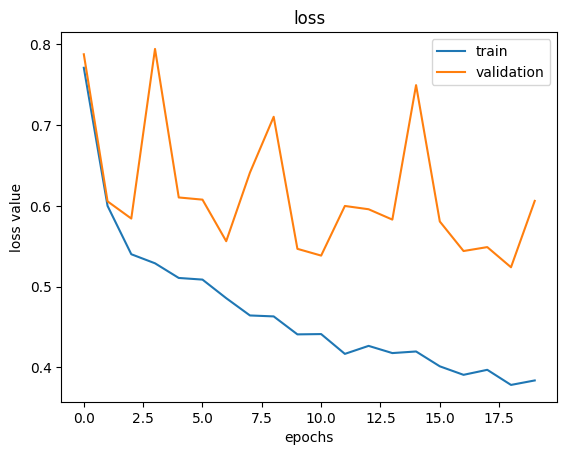

In [53]:
output_metrics(history, "loss")

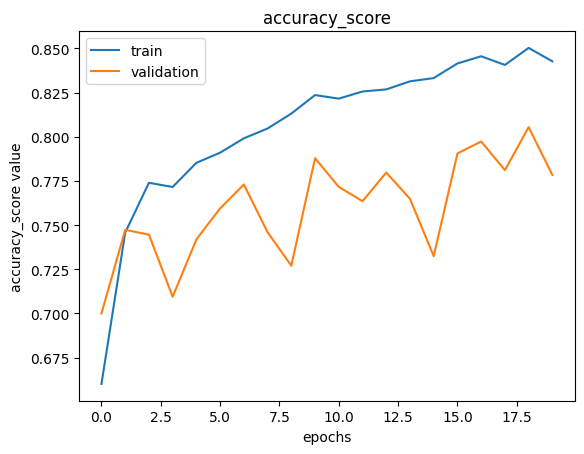

In [54]:
output_metrics(history, "accuracy_score")

In [55]:
test_dl = DataLoader(test_data, batch_size=batch_size, generator=torch.Generator(device = "cpu"), shuffle=True)

In [56]:
def evaluate(model, data):
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    model.eval()
    
    total_loss = 0
    total_acc = 0
    
    with torch.no_grad():
        for x, y in tqdm(data):
    
            x = x.to(device)
            y = y.to(device)
            
            t_preds = model(x)

            # LOSS DOESNT USE PREDICTED METRICS - ONLY UNHANDLED VALUES (BEFORE ARGMAX)
            t_loss = loss_fn(t_preds, y)
            total_loss += t_loss.item()
            
            preds = torch.argmax(t_preds, dim=1)
            t_acc = accuracy_score(preds.cpu().numpy(), y.cpu().numpy())
            total_acc += t_acc.item()
    
    acc = total_acc / len(test_dl)
    loss = total_loss / len(test_dl)
    
    return f"[Loss: {round(loss, 2)}, accuracy: {round(acc, 2)}]"



In [57]:
print(evaluate(model, test_dl))

100%|██████████| 12/12 [00:09<00:00,  1.32it/s]

[Loss: 0.5, accuracy: 0.8]


In [92]:
tensor = torch.rand(3, 224, 224).unsqueeze(0).to(device)

res = model.predict(tensor)
res

tensor([[0.0291, 0.0330, 0.4747, 0.4632]], device='cuda:0')

100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


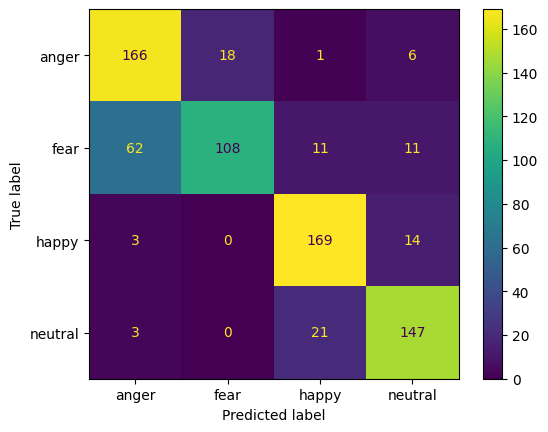

In [105]:
t_model = model.to(device)

y_true = []
y_preds = []


with torch.no_grad():
    for x_test, y_test in tqdm(test_dl):
        
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        pred = t_model(x_test)
    
        y_pred = torch.argmax(pred, dim=1)

        y_true.extend(y_test.cpu().numpy())
        y_preds.extend(y_pred.cpu().numpy())

y_true = np.array(y_true)
y_preds = np.array(y_preds)


ConfusionMatrixDisplay.from_predictions(y_true, y_preds, display_labels=classes)

In [59]:
torch.save(model.state_dict(), "emotion_model.pt")

In [76]:
t_model = EmotionCLassifier()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
weighs = '/kaggle/input/correct-emotion-model/emotion_model.pt'
t_model.load_state_dict(torch.load(weighs))

/tmp/ipykernel_23/1180627904.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_model.load_state_dict(torch.load(weighs))


<All keys matched successfully>

In [61]:
print(evaluate(t_model, test_dl))

100%|██████████| 12/12 [00:08<00:00,  1.36it/s]

[Loss: 0.51, accuracy: 0.8]


In [62]:
def distillation_train(student_model, teacher_model, optimizer, train_dl, val_dl,
          loss_fn_ce, loss_fn_kl, temperature=5, alpha=0.5,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    
    print('train() called: student_model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(student_model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} 
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        student_model.train()
        teacher_model.eval()  # учитель заморожен для дистилляции
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in tqdm(train_dl):
            x = batch[0].to(device)
            y = batch[1].to(device)

            # Получение предсказаний от обеих моделей
            with torch.no_grad():
                teacher_logits = teacher_model(x)

            student_logits = student_model(x)
            
            # usual losses
            loss_hard = loss_fn_ce(student_logits, y)
            
            # losses with KL-divergention - difference between student_logits and teacher_logits divergentions
            loss_soft = loss_fn_kl(
                F.log_softmax(student_logits / temperature, dim=1),
                F.softmax(teacher_logits / temperature, dim=1)
            )
            
            # full loss
            loss = alpha * loss_hard + (1 - alpha) * loss_soft * (temperature ** 2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            student_logits = student_logits.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, student_logits) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = student_logits.round()
                    elif task == 'multiclass': y_pred_ = student_logits.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        student_model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in tqdm(val_dl):
                x = batch[0].to(device)
                y = batch[1].to(device)

                student_logits = student_model(x)
                loss = loss_fn_ce(student_logits, y)

                student_logits = student_logits.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_' + name] += func(y, student_logits) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = student_logits.round()
                        elif task == 'multiclass': y_pred_ = student_logits.argmax(axis=-1)
                        history_val['val_' + name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history


In [93]:
class SmallEmotionCLassifier(nn.Module):
    def __init__(self, outputs = 4):
        super().__init__()
        
        # 3, 224, 224         
        self.block1 = SkipBlock(3, 32, pool = True)
        # 32, 112, 112
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64, 56, 56      
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 128, 28, 28
        self.block4 = SkipBlock(128, 256, pool = True)
        # 256, 14, 14
        self.block5 = SkipBlock(256, 512, pool = True)
        # 512, 7, 7
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool6 = nn.MaxPool2d(kernel_size = 4, stride=4)
        

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(512, 128)
        self.drop = nn.Dropout(0.2)
        self.linear2 = nn.Linear(128, outputs)

    def forward(self, x):
        out = self.block1(x)
        
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool2(out)

        out = self.conv3(out)
        out = F.relu(out)
        out = self.pool3(out)

        out = self.block4(out)
        out = self.block5(out)

        
        out = self.conv6(out)
        out = F.relu(out)
        out = self.pool6(out)


        out = self.flatten(out)

        out = self.linear1(out)
        out = F.relu(out)
        out = self.drop(out)

        res = self.linear2(out)

        return res

        

    def predict(self, x):
        self.eval()
        
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            
            t_res = self.forward(x)
            res = torch.softmax(t_res, dim = 1)
            fin_res = torch.argmax(res, dim = 1)
            
        return fin_res
                

In [83]:
tensor = torch.rand(512, 7, 7)

pool = nn.MaxPool2d(kernel_size = 4, stride = 4)

out = pool(tensor)
out.shape

torch.Size([512, 1, 1])

In [84]:
student_model = SmallEmotionCLassifier()
student_model.to(device)

SmallEmotionCLassifier(
  (block1): SkipBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (add_con): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): SkipBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (add_con): Conv2d(128,

In [94]:
tensor = torch.rand(3, 224, 224)

res = student_model.predict(tensor)
res

/tmp/ipykernel_23/3703161837.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)


tensor([2], device='cuda:0')

In [85]:
summary(student_model, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 32, 224, 224]             896
            Conv2d-3         [-1, 32, 224, 224]           9,248
         MaxPool2d-4         [-1, 32, 112, 112]               0
         SkipBlock-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          18,496
         MaxPool2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]          73,856
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
           Conv2d-11          [-1, 256, 28, 28]         295,168
           Conv2d-12          [-1, 256, 28, 28]         590,080
        MaxPool2d-13          [-1, 256, 14, 14]               0
        SkipBlock-14          [-1, 256,

In [95]:
student_model = student_model
teacher_model = model

In [96]:
student_optim = torch.optim.AdamW(student_model.parameters(), lr=1e-3, weight_decay = 1e-4)

hard_loss = nn.CrossEntropyLoss()  
soft_loss_div = nn.KLDivLoss(reduction='batchmean')  

In [97]:
history = distillation_train(student_model = student_model, teacher_model = teacher_model, optimizer = student_optim, train_dl = train_dl, val_dl = val_dl, 
                             loss_fn_ce = hard_loss, loss_fn_kl = soft_loss_div, epochs = 100, device = device, metrics = [accuracy_score], task = "multiclass")

train() called: student_model=SmallEmotionCLassifier, opt=AdamW(lr=0.001000), epochs=100, device=cuda



100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch    1   91sec	loss:        4.6	val_loss:       1.64	accuracy_score:       0.26	val_accuracy_score:      0.241	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch    2   89sec	loss:       4.57	val_loss:       1.56	accuracy_score:      0.258	val_accuracy_score:      0.241	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch    3   88sec	loss:       4.56	val_loss:       1.44	accuracy_score:      0.259	val_accuracy_score:      0.268	


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch    4   87sec	loss:       4.44	val_loss:       1.67	accuracy_score:      0.285	val_accuracy_score:      0.312	


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch    5   87sec	loss:       4.22	val_loss:       1.42	accuracy_score:      0.326	val_accuracy_score:      0.388	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch    6   90sec	loss:       3.67	val_loss:       1.16	accuracy_score:      0.371	val_accuracy_score:      0.404	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch    7   90sec	loss:       2.96	val_loss:        1.1	accuracy_score:      0.433	val_accuracy_score:      0.409	


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch    8   90sec	loss:       2.56	val_loss:       1.04	accuracy_score:      0.461	val_accuracy_score:      0.464	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch    9   91sec	loss:       2.37	val_loss:       1.21	accuracy_score:      0.482	val_accuracy_score:       0.43	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   10   91sec	loss:       2.18	val_loss:      0.997	accuracy_score:      0.514	val_accuracy_score:        0.5	


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch   11   89sec	loss:       1.95	val_loss:      0.939	accuracy_score:       0.54	val_accuracy_score:      0.528	


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch   12   90sec	loss:        1.8	val_loss:       1.59	accuracy_score:      0.568	val_accuracy_score:      0.455	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   13   90sec	loss:       1.66	val_loss:      0.923	accuracy_score:      0.588	val_accuracy_score:      0.551	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   14   90sec	loss:       1.48	val_loss:      0.841	accuracy_score:      0.625	val_accuracy_score:      0.607	


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch   15   91sec	loss:       1.41	val_loss:      0.919	accuracy_score:      0.646	val_accuracy_score:      0.591	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   16   90sec	loss:       1.29	val_loss:       0.77	accuracy_score:      0.661	val_accuracy_score:      0.642	


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch   17   91sec	loss:       1.26	val_loss:      0.842	accuracy_score:      0.672	val_accuracy_score:      0.654	


100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Epoch   18   89sec	loss:       1.21	val_loss:      0.752	accuracy_score:      0.685	val_accuracy_score:      0.665	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   19   89sec	loss:       1.17	val_loss:       0.82	accuracy_score:      0.686	val_accuracy_score:       0.65	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   20   88sec	loss:       1.13	val_loss:       0.73	accuracy_score:      0.706	val_accuracy_score:      0.672	


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Epoch   21   88sec	loss:        1.1	val_loss:      0.725	accuracy_score:      0.703	val_accuracy_score:        0.7	


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch   22   89sec	loss:       1.05	val_loss:      0.778	accuracy_score:      0.723	val_accuracy_score:      0.696	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   23   88sec	loss:       1.02	val_loss:      0.681	accuracy_score:      0.724	val_accuracy_score:      0.715	


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch   24   90sec	loss:      0.991	val_loss:      0.833	accuracy_score:      0.723	val_accuracy_score:      0.701	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   25   89sec	loss:      0.985	val_loss:      0.752	accuracy_score:      0.722	val_accuracy_score:      0.726	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   26   89sec	loss:      0.963	val_loss:      0.802	accuracy_score:      0.729	val_accuracy_score:      0.693	


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch   27   89sec	loss:      0.964	val_loss:      0.707	accuracy_score:      0.731	val_accuracy_score:      0.723	


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch   28   91sec	loss:       0.91	val_loss:      0.741	accuracy_score:      0.743	val_accuracy_score:      0.708	


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch   29   91sec	loss:      0.907	val_loss:      0.671	accuracy_score:       0.75	val_accuracy_score:       0.72	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   30   90sec	loss:      0.887	val_loss:      0.644	accuracy_score:       0.75	val_accuracy_score:      0.719	


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Epoch   31   89sec	loss:      0.848	val_loss:      0.677	accuracy_score:      0.758	val_accuracy_score:      0.728	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   32   89sec	loss:      0.866	val_loss:      0.672	accuracy_score:      0.755	val_accuracy_score:      0.712	


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch   33   89sec	loss:      0.843	val_loss:      0.626	accuracy_score:      0.766	val_accuracy_score:       0.72	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   34   89sec	loss:      0.846	val_loss:      0.661	accuracy_score:      0.763	val_accuracy_score:       0.72	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   35   90sec	loss:      0.844	val_loss:      0.643	accuracy_score:      0.765	val_accuracy_score:      0.742	


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch   36   92sec	loss:      0.798	val_loss:      0.676	accuracy_score:      0.771	val_accuracy_score:      0.753	


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch   37   93sec	loss:      0.796	val_loss:      0.634	accuracy_score:      0.775	val_accuracy_score:      0.738	


100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Epoch   38   91sec	loss:      0.786	val_loss:      0.658	accuracy_score:      0.779	val_accuracy_score:      0.741	


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch   39   92sec	loss:      0.792	val_loss:      0.552	accuracy_score:      0.776	val_accuracy_score:       0.77	


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch   40   92sec	loss:       0.81	val_loss:      0.624	accuracy_score:      0.771	val_accuracy_score:      0.751	


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch   41   92sec	loss:      0.783	val_loss:      0.658	accuracy_score:      0.777	val_accuracy_score:      0.743	


100%|██████████| 12/12 [00:08<00:00,  1.33it/s]


Epoch   42   93sec	loss:      0.747	val_loss:      0.596	accuracy_score:      0.783	val_accuracy_score:      0.764	


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch   43   93sec	loss:      0.736	val_loss:      0.605	accuracy_score:      0.786	val_accuracy_score:      0.755	


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch   44   92sec	loss:      0.766	val_loss:      0.645	accuracy_score:      0.777	val_accuracy_score:      0.738	


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch   45   92sec	loss:      0.744	val_loss:      0.588	accuracy_score:      0.783	val_accuracy_score:      0.765	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   46   92sec	loss:      0.749	val_loss:      0.589	accuracy_score:      0.785	val_accuracy_score:      0.757	


100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Epoch   47   90sec	loss:      0.726	val_loss:      0.593	accuracy_score:      0.789	val_accuracy_score:      0.762	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   48   90sec	loss:      0.727	val_loss:      0.661	accuracy_score:      0.789	val_accuracy_score:      0.735	


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch   49   91sec	loss:      0.718	val_loss:      0.609	accuracy_score:      0.791	val_accuracy_score:       0.75	


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch   50   89sec	loss:      0.719	val_loss:       0.57	accuracy_score:      0.791	val_accuracy_score:      0.743	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   51   89sec	loss:      0.703	val_loss:      0.667	accuracy_score:      0.792	val_accuracy_score:      0.745	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   52   90sec	loss:      0.709	val_loss:      0.544	accuracy_score:      0.797	val_accuracy_score:      0.769	


100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Epoch   53   90sec	loss:      0.704	val_loss:      0.533	accuracy_score:      0.798	val_accuracy_score:      0.766	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   54   90sec	loss:      0.686	val_loss:      0.635	accuracy_score:      0.794	val_accuracy_score:      0.749	


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch   55   89sec	loss:      0.679	val_loss:      0.558	accuracy_score:      0.802	val_accuracy_score:      0.758	


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch   56   90sec	loss:      0.659	val_loss:      0.548	accuracy_score:      0.805	val_accuracy_score:      0.778	


100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Epoch   57   89sec	loss:      0.666	val_loss:      0.557	accuracy_score:      0.803	val_accuracy_score:      0.764	


100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Epoch   58   89sec	loss:      0.659	val_loss:      0.627	accuracy_score:      0.797	val_accuracy_score:      0.754	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   59   89sec	loss:      0.653	val_loss:      0.565	accuracy_score:      0.805	val_accuracy_score:      0.774	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   60   90sec	loss:      0.652	val_loss:      0.559	accuracy_score:      0.809	val_accuracy_score:      0.777	


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch   61   89sec	loss:      0.645	val_loss:      0.561	accuracy_score:      0.807	val_accuracy_score:      0.768	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   62   89sec	loss:      0.646	val_loss:       0.59	accuracy_score:      0.807	val_accuracy_score:      0.759	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   63   89sec	loss:      0.647	val_loss:       0.57	accuracy_score:      0.806	val_accuracy_score:      0.766	


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch   64   90sec	loss:      0.639	val_loss:       0.58	accuracy_score:      0.807	val_accuracy_score:      0.769	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   65   90sec	loss:       0.66	val_loss:      0.546	accuracy_score:       0.81	val_accuracy_score:       0.77	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   66   89sec	loss:      0.619	val_loss:      0.561	accuracy_score:      0.809	val_accuracy_score:      0.766	


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch   67   89sec	loss:      0.649	val_loss:      0.591	accuracy_score:      0.802	val_accuracy_score:      0.755	


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Epoch   68   89sec	loss:      0.627	val_loss:      0.579	accuracy_score:      0.807	val_accuracy_score:      0.764	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   69   89sec	loss:      0.619	val_loss:      0.612	accuracy_score:       0.81	val_accuracy_score:      0.761	


100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Epoch   70   89sec	loss:      0.627	val_loss:      0.577	accuracy_score:      0.809	val_accuracy_score:      0.759	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   71   89sec	loss:      0.622	val_loss:      0.624	accuracy_score:      0.816	val_accuracy_score:      0.773	


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch   72   89sec	loss:      0.618	val_loss:      0.579	accuracy_score:      0.808	val_accuracy_score:      0.754	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   73   89sec	loss:      0.612	val_loss:      0.532	accuracy_score:      0.817	val_accuracy_score:      0.774	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   74   89sec	loss:      0.614	val_loss:      0.551	accuracy_score:      0.812	val_accuracy_score:       0.77	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   75   89sec	loss:      0.584	val_loss:      0.549	accuracy_score:      0.821	val_accuracy_score:      0.776	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   76   88sec	loss:      0.602	val_loss:      0.557	accuracy_score:       0.82	val_accuracy_score:      0.781	


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch   77   89sec	loss:      0.595	val_loss:      0.543	accuracy_score:       0.82	val_accuracy_score:      0.782	


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch   78   89sec	loss:      0.609	val_loss:      0.535	accuracy_score:      0.819	val_accuracy_score:       0.78	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   79   90sec	loss:      0.591	val_loss:      0.566	accuracy_score:      0.818	val_accuracy_score:      0.762	


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch   80   90sec	loss:      0.618	val_loss:      0.576	accuracy_score:      0.813	val_accuracy_score:      0.764	


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch   81   90sec	loss:      0.587	val_loss:      0.506	accuracy_score:      0.823	val_accuracy_score:      0.781	


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch   82   92sec	loss:      0.585	val_loss:      0.548	accuracy_score:       0.82	val_accuracy_score:      0.772	


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch   83   93sec	loss:      0.589	val_loss:      0.598	accuracy_score:      0.818	val_accuracy_score:      0.774	


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch   84   93sec	loss:      0.595	val_loss:      0.536	accuracy_score:      0.813	val_accuracy_score:       0.78	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   85   91sec	loss:      0.583	val_loss:      0.519	accuracy_score:      0.824	val_accuracy_score:      0.793	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   86   89sec	loss:      0.569	val_loss:      0.548	accuracy_score:      0.825	val_accuracy_score:       0.77	


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch   87   90sec	loss:      0.584	val_loss:      0.515	accuracy_score:      0.815	val_accuracy_score:      0.772	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   88   90sec	loss:      0.568	val_loss:      0.536	accuracy_score:      0.817	val_accuracy_score:      0.781	


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch   89   91sec	loss:      0.568	val_loss:      0.556	accuracy_score:      0.825	val_accuracy_score:      0.773	


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch   90   90sec	loss:      0.562	val_loss:      0.528	accuracy_score:      0.823	val_accuracy_score:      0.772	


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch   91   92sec	loss:      0.549	val_loss:      0.529	accuracy_score:      0.828	val_accuracy_score:       0.77	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   92   92sec	loss:      0.568	val_loss:      0.597	accuracy_score:      0.824	val_accuracy_score:      0.746	


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch   93   93sec	loss:      0.571	val_loss:      0.548	accuracy_score:      0.827	val_accuracy_score:       0.77	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   94   90sec	loss:      0.578	val_loss:      0.527	accuracy_score:      0.823	val_accuracy_score:      0.784	


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch   95   90sec	loss:      0.547	val_loss:      0.567	accuracy_score:      0.829	val_accuracy_score:      0.772	


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   96   89sec	loss:      0.548	val_loss:      0.549	accuracy_score:      0.836	val_accuracy_score:      0.764	


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch   97   90sec	loss:      0.568	val_loss:      0.573	accuracy_score:      0.821	val_accuracy_score:      0.781	


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch   98   90sec	loss:      0.541	val_loss:      0.532	accuracy_score:      0.834	val_accuracy_score:      0.765	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch   99   91sec	loss:       0.56	val_loss:      0.541	accuracy_score:      0.827	val_accuracy_score:      0.777	


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]

Epoch  100   90sec	loss:      0.533	val_loss:      0.546	accuracy_score:      0.837	val_accuracy_score:      0.769	

Time total:     8996.66 sec


In [98]:
evaluate(student_model, test_dl)

100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


'[Loss: 0.52, accuracy: 0.8]'

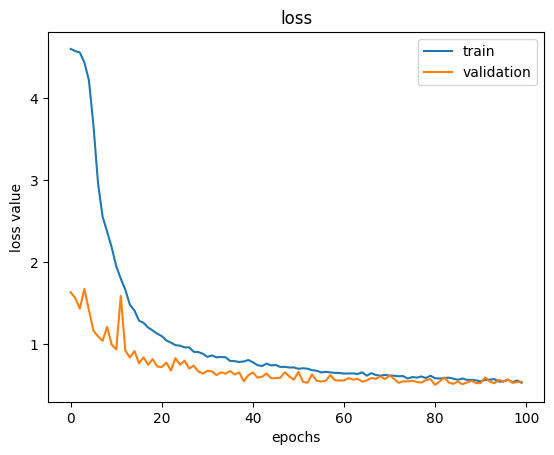

In [99]:
output_metrics(history, "loss")

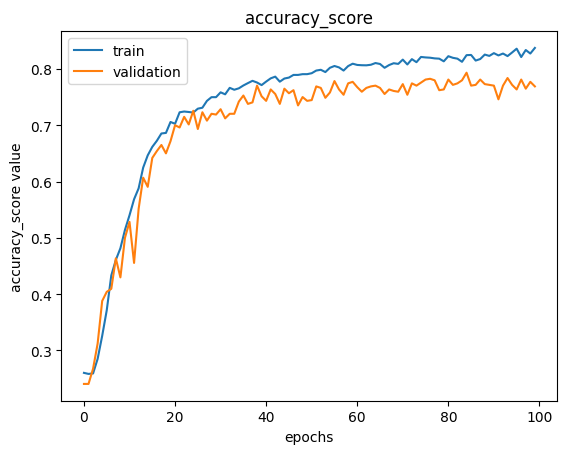

In [100]:
output_metrics(history, "accuracy_score")

In [101]:
classes

['anger', 'fear', 'happy', 'neutral']

In [104]:
for x, y in tqdm(test_dl):
    print(x)
    print(y)
    break

  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


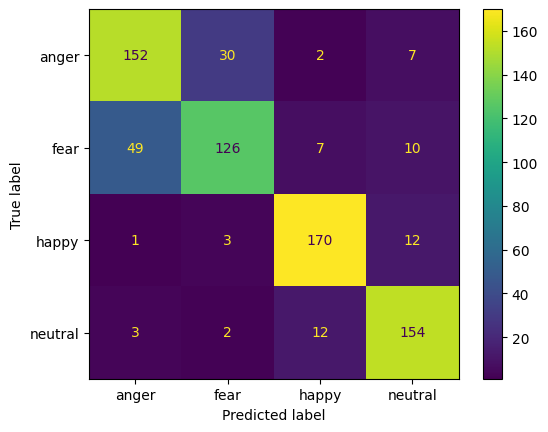

In [119]:
t_model = student_model.to(device)

y_true = []
y_preds = []

with torch.no_grad():
    for x_test, y_test in tqdm(test_dl):
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        pred = t_model(x_test)
        y_pred = torch.argmax(pred, dim = 1)

        y_true.extend(y_test.cpu().numpy())
        y_preds.extend(y_pred.cpu().numpy())
        

y_true = np.array(y_true)
y_preds = np.array(y_preds)


ConfusionMatrixDisplay.from_predictions(y_true, y_preds, display_labels=classes)

In [120]:
torch.save(student_model.state_dict(), "compact_emotion_model.pt")

In [122]:
t_model = SmallEmotionCLassifier()

weights_dir = '/kaggle/working/compact_emotion_model.pt'
t_model.load_state_dict(torch.load(weights_dir))

/tmp/ipykernel_23/1821622139.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_model.load_state_dict(torch.load(weights_dir))


<All keys matched successfully>

In [128]:
tensor = torch.rand((3, 224, 224)).to(device)
t_model.to(device)
res = t_model.predict(tensor)
res

/tmp/ipykernel_23/3703161837.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)


tensor([1], device='cuda:0')